<a href="https://colab.research.google.com/github/Hyperion8642/datathon_2026_asj/blob/main/datathon_EDA_saeah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connect to google drive and read data
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/Access_to_Everyday_Life_Dataset.csv'

df = pd.read_csv(file_path)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,type,geometry/type,geometry/coordinates/0,geometry/coordinates/1,properties/attribute_id,properties/label_type,properties/neighborhood,properties/severity,properties/is_temporary
0,Feature,Point,-122.298981,47.594616,52096165,SurfaceProblem,Atlantic,4.0,False
1,Feature,Point,-122.301071,47.593357,52096166,SurfaceProblem,Atlantic,3.0,False
2,Feature,Point,-122.301079,47.596844,52096167,SurfaceProblem,Atlantic,4.0,False
3,Feature,Point,-122.301071,47.596500,52096168,SurfaceProblem,Atlantic,4.0,False
4,Feature,Point,-122.306274,47.599930,52096365,NoCurbRamp,Atlantic,4.0,False


<class 'pandas.core.frame.DataFrame'>
Index: 79722 entries, 0 to 81972
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   geometry/coordinates/0   79722 non-null  float64
 1   geometry/coordinates/1   79722 non-null  float64
 2   properties/label_type    79722 non-null  object 
 3   properties/neighborhood  79722 non-null  object 
 4   properties/is_temporary  79722 non-null  int64  
 5   properties/severity      79722 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 4.3+ MB


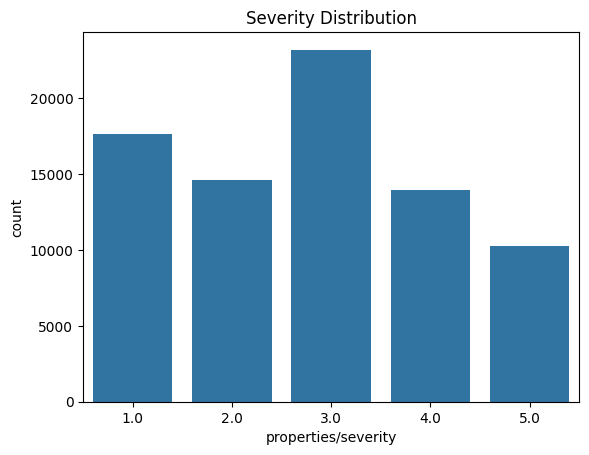

In [ ]:
df.info()
df.describe(include='all')
df.head()

# Check severity distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='properties/severity', data=df)
plt.title("Severity Distribution")
plt.show()

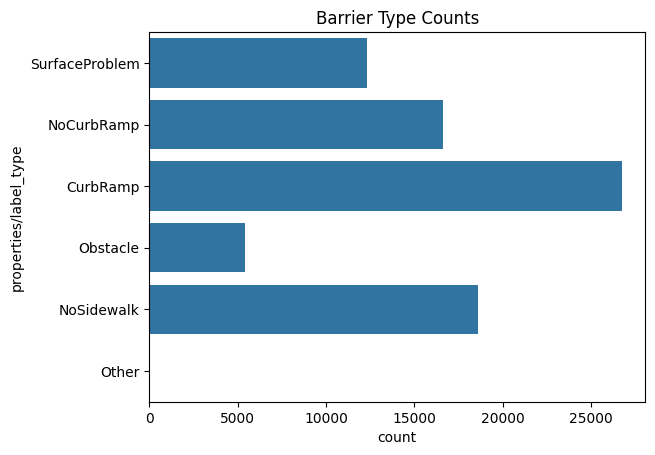

In [ ]:
# Check barrier type
sns.countplot(y='properties/label_type', data=df)
plt.title("Barrier Type Counts")
plt.show()

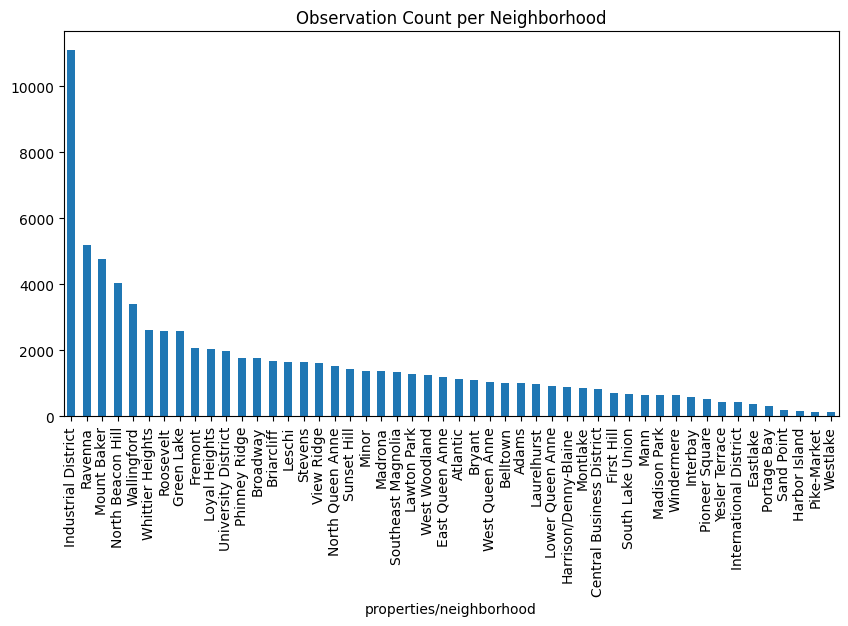

In [ ]:
# Check neighborhoods
neigh_counts = df['properties/neighborhood'].value_counts()
neigh_counts.plot(kind='bar', figsize=(10,5))
plt.title("Observation Count per Neighborhood")
plt.show()

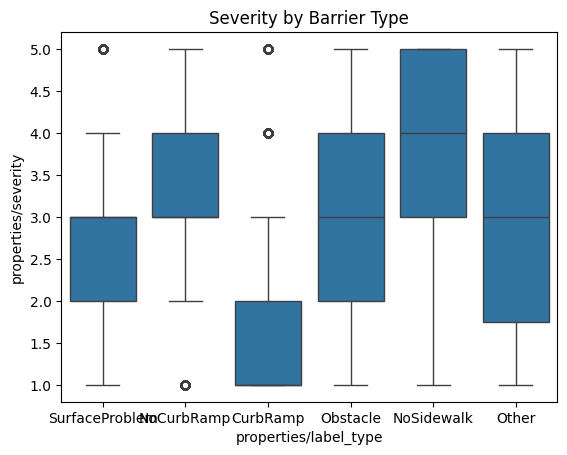

In [ ]:
# severity vs barrier type
sns.boxplot(x='properties/label_type', y='properties/severity', data=df)
plt.title("Severity by Barrier Type")
plt.show()

Combine with Geojson data to correctly label neighborhood

In [ ]:
!pip install geopandas shapely

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Conver df to GeoDataFrame
# longitude = x, latitude = y
df['geometry'] = df.apply(lambda row: Point(row['geometry/coordinates/0'], row['geometry/coordinates/1']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Load GeoJSON
neighborhoods = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Neighborhood_Map_Atlas_Neighborhoods.geojson")

# Spatial join
gdf_corrected = gpd.sjoin(gdf, neighborhoods[['L_HOOD','S_HOOD','geometry']], how='left', predicate='within')

# Add a new column: Corrected Neighborhood
gdf_corrected['corrected_neighborhood'] = gdf_corrected['S_HOOD']

gdf_corrected = gdf_corrected.drop(columns=['index_right'])

gdf_corrected[['geometry/coordinates/0', 'geometry/coordinates/1', 'properties/neighborhood', 'corrected_neighborhood']].head(100)

,geometry/coordinates/0,geometry/coordinates/1,properties/neighborhood,corrected_neighborhood
0,-122.298981,47.594616,Atlantic,Atlantic
1,-122.301071,47.593357,Atlantic,Atlantic
2,-122.301079,47.596844,Atlantic,Atlantic
3,-122.301071,47.596500,Atlantic,Atlantic
4,-122.306274,47.599930,Atlantic,Atlantic
...,...,...,...,...
100,-122.375755,47.669640,West Woodland,West Woodland
101,-122.363953,47.668762,West Woodland,West Woodland
102,-122.364128,47.669369,West Woodland,West Woodland
103,-122.301285,47.596420,Atlantic,Atlantic


In [ ]:
!pip install folium geopandas

import folium
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# Set the center as Seattle downtown area
seattle_center = [47.6062, -122.3321]  # lat, lon
m = folium.Map(location=seattle_center, zoom_start=12)

# Color by neighborhood (labeling)
neighborhoods_unique = gdf_corrected['corrected_neighborhood'].dropna().unique()
cmap = plt.get_cmap('Set3', len(neighborhoods_unique))  # Colormap
colors = [mcolors.rgb2hex(cmap(i)) for i in range(len(neighborhoods_unique))]  # RGB → HEX
color_dict = dict(zip(neighborhoods_unique, colors))

# Create map with folium
seattle_center = [47.6062, -122.3321]
m = folium.Map(location=seattle_center, zoom_start=12)

for idx, row in gdf_corrected.iterrows():
    folium.CircleMarker(
        location=[row['geometry/coordinates/1'], row['geometry/coordinates/0']],
        radius=3,
        color=color_dict.get(row['corrected_neighborhood'], 'gray'),
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['properties/neighborhood']} → {row['corrected_neighborhood']}"
    ).add_to(m)

m